# Try 1

In [2]:
import pandas as pd

# Load the CSV file
file_path = './Data/2023/stanford_2023_lines.csv'
stanford_data = pd.read_csv(file_path)


In [3]:
# Define a function to extract Stanford's moneyline odds based on their location (home or away)
def extract_stanford_odds(row):
    if row['HomeTeam'] == 'Stanford':
        return row['HomeMoneyline']
    elif row['AwayTeam'] == 'Stanford':
        return row['AwayMoneyline']
    return None

# Apply the function to get Stanford's odds for each game
stanford_data['StanfordMoneyline'] = stanford_data.apply(extract_stanford_odds, axis=1)

# Select relevant columns for output
output = stanford_data[['Id', 'HomeTeam', 'AwayTeam', 'LineProvider', 'StanfordMoneyline']]

# Print the results
output.head(5)  # Display the first 20 rows to check the output in Jupyter Notebook


,Id,HomeTeam,AwayTeam,LineProvider,StanfordMoneyline
0,401524029,Colorado,Stanford,William Hill (New Jersey),NaN
1,401524029,Colorado,Stanford,Bovada,340.0
2,401524029,Colorado,Stanford,DraftKings,340.0
3,401524061,Stanford,California,ESPN Bet,NaN
4,401524061,Stanford,California,Bovada,210.0


In [4]:
# Filter out rows where the LineProvider is either "William Hill (New Jersey)" or "ESPN Bet"
filtered_data = stanford_data[
    (stanford_data['LineProvider'] != 'William Hill (New Jersey)') &
    (stanford_data['LineProvider'] != 'ESPN Bet') &
    (stanford_data['LineProvider'] != 'Caesars Sportsbook (Colorado)') &
    (stanford_data['LineProvider'] != 'teamrankings') &
    (stanford_data['LineProvider'] != 'DraftKings')
]

# Select relevant columns for output
filtered_output = filtered_data[['HomeTeam', 'HomeScore', 'AwayTeam', 'AwayScore','LineProvider', 'OpeningSpread','StanfordMoneyline']]

# Print the filtered results
filtered_output.head(25)

,HomeTeam,HomeScore,AwayTeam,AwayScore,LineProvider,OpeningSpread,StanfordMoneyline
1,Colorado,43,Stanford,46,Bovada,-11.5,340.0
4,Stanford,15,California,27,Bovada,4.5,210.0
8,Stanford,6,Oregon,42,Bovada,27.0,1200.0
11,Stanford,20,Arizona,21,Bovada,10.0,290.0
14,Stanford,33,Washington,42,Bovada,26.5,1300.0
18,Washington State,7,Stanford,10,Bovada,-13.5,400.0
21,Stanford,23,Notre Dame,56,Bovada,24.5,1100.0
25,Hawai'i,24,Stanford,37,Bovada,8.0,-285.0
28,Oregon State,62,Stanford,17,Bovada,-20.5,850.0
31,USC,56,Stanford,10,Bovada,-30.0,1600.0


In [5]:
# Function to calculate the dollar reward based on a fixed $100 bet
def calculate_dollar_reward(row, action):
    bet_amount = 100
    if action == 'bet_spread':
        if row['HomeTeam'] == 'Stanford' and (row['HomeScore'] - row['AwayScore']) > row['OpeningSpread']:
            return bet_amount * 0.91  # Win $91 on a $100 bet
        elif row['AwayTeam'] == 'Stanford' and (row['AwayScore'] - row['HomeScore']) > -row['OpeningSpread']:
            return bet_amount * 0.91  # Win $91 on a $100 bet
        else:
            return -bet_amount  # Lose the entire bet amount

    elif action == 'bet_moneyline':
        if row['HomeTeam'] == 'Stanford' and row['HomeScore'] > row['AwayScore']:
            odds = row['StanfordMoneyline']
            if odds > 0:  # Positive odds (e.g., +150)
                return bet_amount * (odds / 100)
            else:  # Negative odds (e.g., -150)
                return bet_amount / abs(odds) * 100
        elif row['AwayTeam'] == 'Stanford' and row['AwayScore'] > row['HomeScore']:
            odds = row['StanfordMoneyline']
            if odds > 0:
                return bet_amount * (odds / 100)
            else:
                return bet_amount / abs(odds) * 100
        else:
            return -bet_amount  # Lose the entire bet amount

    elif action == 'no_bet':
        return 0

# Define the MDP framework with logging capabilities
class StanfordBettingMDP:
    def __init__(self, data):
        self.data = data
        self.action_log = []  # Log to store actions and rewards for each game
    
    def get_state(self, row):
        return {
            'location': 'home' if row['HomeTeam'] == 'Stanford' else 'away',
            'opponent_strength': row['StanfordMoneyline'],
            'spread': row['OpeningSpread']
        }
    
    def get_actions(self):
        return ['bet_spread', 'bet_moneyline', 'no_bet']
    
    def reward(self, row, action):
        return calculate_dollar_reward(row, action)
    
    def simulate_policy(self, policy):
        total_reward = 0
        for _, row in self.data.iterrows():
            state = self.get_state(row)
            action = policy(state)
            action_reward = self.reward(row, action)
            total_reward += action_reward
            
            # Log each game with action and reward
            self.action_log.append({
                'HomeTeam': row['HomeTeam'],
                'HomeScore': row['HomeScore'],
                'AwayTeam': row['AwayTeam'],
                'AwayScore': row['AwayScore'],
                'LineProvider': row['LineProvider'],
                'OpeningSpread': row['OpeningSpread'],
                'StanfordMoneyline': row['StanfordMoneyline'],
                'Action': action,
                'Reward': action_reward
            })
        return total_reward

# Example policy function
def example_policy(state):
    if state['opponent_strength'] > 300:
        return 'bet_moneyline'
    elif abs(state['spread']) > 10:
        return 'bet_spread'
    else:
        return 'no_bet'

# Instantiate the MDP, run the policy, and create a DataFrame from the action log
mdp = StanfordBettingMDP(filtered_data)
total_reward = mdp.simulate_policy(example_policy)
action_log_df = pd.DataFrame(mdp.action_log)

# Display the results
print("Total Dollar Reward:", total_reward)
print("\nDetailed Game Log with Actions and Rewards:")
action_log_df.head(25) # Show the first 25 rows as an example

Total Dollar Reward: 140.0

Detailed Game Log with Actions and Rewards:


,HomeTeam,HomeScore,AwayTeam,AwayScore,LineProvider,OpeningSpread,StanfordMoneyline,Action,Reward
0,Colorado,43,Stanford,46,Bovada,-11.5,340.0,bet_moneyline,340.0
1,Stanford,15,California,27,Bovada,4.5,210.0,no_bet,0.0
2,Stanford,6,Oregon,42,Bovada,27.0,1200.0,bet_moneyline,-100.0
3,Stanford,20,Arizona,21,Bovada,10.0,290.0,no_bet,0.0
4,Stanford,33,Washington,42,Bovada,26.5,1300.0,bet_moneyline,-100.0
5,Washington State,7,Stanford,10,Bovada,-13.5,400.0,bet_moneyline,400.0
6,Stanford,23,Notre Dame,56,Bovada,24.5,1100.0,bet_moneyline,-100.0
7,Hawai'i,24,Stanford,37,Bovada,8.0,-285.0,no_bet,0.0
8,Oregon State,62,Stanford,17,Bovada,-20.5,850.0,bet_moneyline,-100.0
9,USC,56,Stanford,10,Bovada,-30.0,1600.0,bet_moneyline,-100.0


# Try 2

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the data
metrics_df = pd.read_csv('./Data/2023/stanford_2023_advancedmetrics_altered.csv')
gamestats_df = pd.read_csv('./Data/2023/stanford_2023_gamestats_altered.csv')
lines_df = pd.read_csv('./Data/2023/stanford_2023_lines_altered.csv')

# Combine relevant data into a single DataFrame, aligned by week
data_df = pd.concat([metrics_df, gamestats_df, lines_df], axis=1)

#Save concatanated data
#data_df.to_csv('concat_stanford_2023.csv',index=False)

# MDP parameters
actions = ['bet', 'no_bet']
bet_amount = 100  # Fixed amount to bet each week
expected_value_threshold = 5  # Expected value threshold for betting (adjustable)

# Initialize variables
total_reward = 0  # Track total profit or loss
rewards = []      # Record cumulative reward outcomes for each week

# Define the reward function based on the bet outcome and odds
def reward(action, odds, outcome):
    if action == 'bet':
        if outcome > 0:  # Win scenario
            if odds > 0:
                return bet_amount * (odds / 100)  # Positive odds (e.g., +150)
            else:
                return bet_amount * (100 / abs(odds))  # Negative odds (e.g., -150)
        else:
            return -bet_amount  # Loss scenario, lose full $100
    return 0  # No reward if no bet

# Function to extract Stanford's moneyline odds and determine game outcome
def get_stanford_moneyline_and_outcome(row):
    if row['HomeTeam'] == 'Stanford':
        odds = row['HomeMoneyline']
        outcome = 1 if row['HomeScore'] > row['AwayScore'] else -1  # 1 if win, -1 if loss
        stanford_elo = row['Home Pregame Elo']
        opponent_elo = row['Away Pregame Elo']
    elif row['AwayTeam'] == 'Stanford':
        odds = row['AwayMoneyline']
        outcome = 1 if row['AwayScore'] > row['HomeScore'] else -1  # 1 if win, -1 if loss
        stanford_elo = row['Away Pregame Elo']
        opponent_elo = row['Home Pregame Elo']
    else:
        odds, outcome, stanford_elo, opponent_elo = None, None, None, None  # This case shouldn't happen based on your dataset
    return odds, outcome, stanford_elo, opponent_elo

# Expected value calculation
def calculate_expected_value(odds, win_prob):
    if odds > 0:
        return bet_amount * (win_prob * (odds / 100) - (1 - win_prob))
    else:
        return bet_amount * (win_prob * (100 / abs(odds)) - (1 - win_prob))

# Simple policy to decide action based on Elo ratings comparison and expected value
def decide_action(row):
    odds, outcome, stanford_elo, opponent_elo = get_stanford_moneyline_and_outcome(row)
    if odds is None:
        return 'no_bet', 0  # Skip if Stanford did not play
    
    # Calculate win probability based on the Elo rating difference
    elo_diff = stanford_elo - opponent_elo
    win_prob = 1 / (1 + 10 ** (-elo_diff / 400))  # Win probability from Elo difference
    
    # Calculate expected value
    ev = calculate_expected_value(odds, win_prob)
    
    # Decision based on expected value
    if ev >= expected_value_threshold:
        return 'bet', odds
    else:
        return 'no_bet', odds

# Simulate sequential decision-making through the season
for week in range(1, len(data_df)):
    current_state = data_df.iloc[:week]  # Include data up to the current week
    next_state = data_df.iloc[week]
    
    # Decide action based on the policy
    action, odds = decide_action(next_state)
    
    # Calculate the reward for this week's action
    odds, outcome, _, _ = get_stanford_moneyline_and_outcome(next_state)
    week_reward = reward(action, odds, outcome)
    total_reward += week_reward
    rewards.append(total_reward)  # Track cumulative reward
    
    # Log action and reward for analysis
    print(f"Week {week}: Action: {action}, Odds: {odds}, Outcome: {outcome}, Cumulative Reward: {total_reward}")

print("Total Cumulative Reward:", total_reward)

Week 1: Action: bet, Odds: 1600.0, Outcome: -1, Cumulative Reward: -100
Week 2: Action: no_bet, Odds: 290.0, Outcome: -1, Cumulative Reward: -100
Week 3: Action: no_bet, Odds: 1200.0, Outcome: -1, Cumulative Reward: -100
Week 4: Action: bet, Odds: 340.0, Outcome: 1, Cumulative Reward: 240.0
Week 5: Action: no_bet, Odds: 550.0, Outcome: -1, Cumulative Reward: 240.0
Week 6: Action: no_bet, Odds: 1300.0, Outcome: -1, Cumulative Reward: 240.0
Week 7: Action: bet, Odds: 400.0, Outcome: 1, Cumulative Reward: 640.0
Week 8: Action: no_bet, Odds: 850.0, Outcome: -1, Cumulative Reward: 640.0
Week 9: Action: no_bet, Odds: 210.0, Outcome: -1, Cumulative Reward: 640.0
Week 10: Action: no_bet, Odds: 1100.0, Outcome: -1, Cumulative Reward: 640.0
Total Cumulative Reward: 640.0


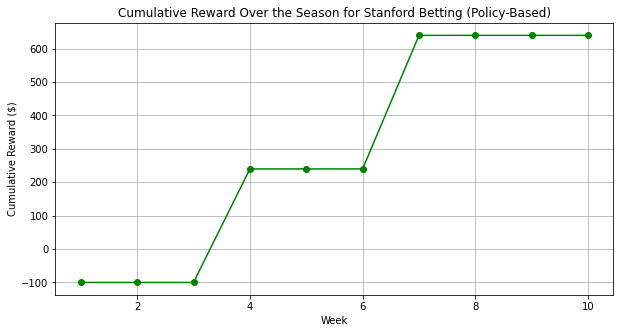

In [3]:
import matplotlib.pyplot as plt

# Plotting cumulative reward over weeks
weeks = list(range(1, len(rewards) + 1))
plt.figure(figsize=(10, 5))
plt.plot(weeks, rewards, marker='o', linestyle='-', color='g')
plt.title("Cumulative Reward Over the Season for Stanford Betting (Policy-Based)")
plt.xlabel("Week")
plt.ylabel("Cumulative Reward ($)")
plt.grid(True)
plt.show()

In [4]:
#data_df.to_csv('concat_stanford_2023.csv',index=False)
data_df.head(15)

,GameId,Week,Team,Opponent,Offense Plays,Offense Drives,Offense Ppa,Offense TotalPPA,Offense SuccessRate,Offense Explosiveness,...,AwayTeam,AwayScore,LineProvider,OverUnder,Spread,FormattedSpread,OpeningSpread,OpeningOverUnder,HomeMoneyline,AwayMoneyline
0,401523988,1,Stanford,Hawai'i,67,11,0.232013,15.544844,0.462687,1.241753,...,Stanford,37,Bovada,54.5,2.5,Stanford -2.5,8.0,58.5,235.0,-285.0
1,401524003,2,Stanford,USC,66,14,-0.122133,-8.060770,0.393939,1.156977,...,Stanford,10,Bovada,70.0,-28.5,USC -28.5,-30.0,71.0,-10000.0,1600.0
2,401524016,4,Stanford,Arizona,66,10,0.153373,10.122589,0.409091,1.351993,...,Arizona,21,Bovada,59.5,13.0,Arizona -13.0,10.0,59.0,290.0,-380.0
3,401524024,5,Stanford,Oregon,70,9,-0.104485,-7.313962,0.357143,1.070678,...,Oregon,42,Bovada,61.0,27.0,Oregon -27.0,27.0,61.0,1200.0,-4000.0
4,401524029,7,Stanford,Colorado,86,14,0.255788,21.997803,0.476744,1.216817,...,Stanford,46,Bovada,59.0,-13.0,Colorado -13.0,-11.5,59.0,-460.0,340.0
5,401524036,8,Stanford,UCLA,62,13,0.023353,1.447905,0.322581,1.309574,...,UCLA,42,Bovada,51.5,17.0,UCLA -17.0,16.5,54.0,550.0,-850.0
6,401524042,9,Stanford,Washington,80,14,0.296445,23.715596,0.487500,1.149510,...,Washington,42,Bovada,62.0,28.0,Washington -28.0,26.5,59.5,1300.0,-5000.0
7,401524050,10,Stanford,Washington State,70,11,-0.062424,-4.369673,0.300000,1.056761,...,Stanford,10,Bovada,58.0,-14.0,Washington State -14.0,-13.5,61.0,-575.0,400.0
8,401524054,11,Stanford,Oregon State,63,13,0.033653,2.120125,0.285714,1.958142,...,Stanford,17,Bovada,52.5,-21.5,Oregon State -21.5,-20.5,54.5,-1800.0,850.0
9,401524061,12,Stanford,California,57,12,0.040535,2.310467,0.298246,1.513605,...,California,27,Bovada,53.5,7.0,California -7.0,4.5,57.5,210.0,-250.0
